<a href="https://colab.research.google.com/github/dhamvi01/Monte-Carlo-Simulation-with-Python/blob/main/Monte_Carlo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

we know that our historical percent to target performance is centered around a a mean of 100% and standard deviation of 10%. Let’s define those variables as well as the number of sales reps and simulations we are modeling

In [3]:
avg = 1
std_dev = .1
num_reps = 500
num_simulations = 1000

Now we can use numpy to generate a list of percentages that will replicate our historical normal distribution

In [4]:
pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

 we will use a uniform distribution but assign lower probability rates for some of the values.

In [5]:
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

Now that we know how to create our two input distributions, let’s build up a pandas dataframe:

In [9]:
df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                               'Sales_Target': sales_target})

df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']
df

,Pct_To_Target,Sales_Target,Sales
0,0.97,200000,194000.0
1,1.05,500000,525000.0
2,1.10,200000,220000.0
3,1.00,500000,500000.0
4,0.96,75000,72000.0
...,...,...,...
495,0.91,100000,91000.0
496,1.12,300000,336000.0
497,1.02,500000,510000.0
498,0.99,100000,99000.0


You might notice that I did a little trick to calculate the actual sales amount. For this problem, the actual sales amount may change greatly over the years but the performance distribution remains remarkably consistent. Therefore, I’m using the random distributions to generate my inputs and backing into the actual sales.

The final piece of code we need to create is a way to map our Pct_To_Target to the commission rate. Here is the function:

In [10]:
def calc_commission_rate(x):
    """ Return the commission rate based on the table:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

Now we create our commission rate and multiply it times sales

In [11]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']
df

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,0.97,200000,194000.0,0.03,5820.0
1,1.05,500000,525000.0,0.04,21000.0
2,1.10,200000,220000.0,0.04,8800.0
3,1.00,500000,500000.0,0.04,20000.0
4,0.96,75000,72000.0,0.03,2160.0
...,...,...,...,...,...
495,0.91,100000,91000.0,0.03,2730.0
496,1.12,300000,336000.0,0.04,13440.0
497,1.02,500000,510000.0,0.04,20400.0
498,0.99,100000,99000.0,0.03,2970.0


### Let’s Loop

In [12]:
all_stats = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose random inputs for the sales targets and percent to target
    sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Back into the sales number using the percent to target rate
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Determine the commissions rate and calculate it
    df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # We want to track sales,commission amounts and sales targets over all the simulations
    all_stats.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

In order to analyze the results of the simulation, I will build a dataframe from all_stats :

In [13]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Sales',
                                                           'Commission_Amount',
                                                           'Sales_Target'])

In [14]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,722,071.0","2,858,303.489","83,723,150.0"
std,"2,842,219.531933046","106,809.07707256425","2,797,191.378348487"
min,"74,615,000.0","2,494,982.0","74,875,000.0"
25%,"81,762,562.5","2,785,325.0","81,825,000.0"
50%,"83,765,125.0","2,855,525.0","83,737,500.0"
75%,"85,534,750.0","2,932,741.75","85,500,000.0"
max,"92,615,500.0","3,226,045.0","92,325,000.0"


In [15]:
results_df

,Sales,Commission_Amount,Sales_Target
0,81066000.0,2750428.0,81525000
1,84817000.0,2894580.0,85100000
2,83485250.0,2848018.0,83600000
3,85441500.0,2935110.0,85600000
4,86122750.0,2943375.0,85900000
...,...,...,...
995,84947750.0,2879275.0,84650000
996,81973250.0,2807848.0,82125000
997,85195250.0,2934685.0,84625000
998,83851250.0,2897495.0,83575000


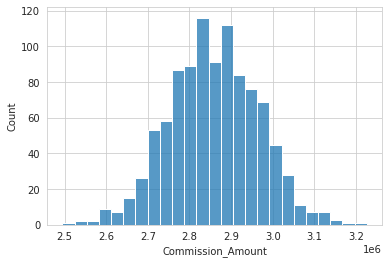

In [18]:
sns.histplot(data=results_df, x="Commission_Amount")

So, what does this chart and the output of describe tell us? We can see that the average commissions expense is 2.85M and the standard deviation is 103K. We can also see that the commissions payment can be as low as 2.5M or as high as 3.2M.

Based on these results, how comfortable are you that the expense for commissions will be less than 3M? Or, if someone says, "Let’s only budget 2.7M" would you feel comfortable that your expenses would be below that amount? Probably not.

Therein lies one of the benefits of the Monte Carlo simulation. You develop a better understanding of the distribution of likely outcomes and can use that knowledge plus your business acumen to make an informed estimate.

The other value of this model is that you can model many different assumptions and see what happens. Here are some simple changes you can make to see how the results change:

Increase top commission rate to 5%
Decrease the number of sales people
Change the expected standard deviation to a higher amount
Modify the distribution of targets

Another observation about Monte Carlo simulations is that they are relatively easy to explain to the end user of the prediction. The person receiving this estimate may not have a deep mathematical background but can intuitively understand what this simulation is doing and how to assess the likelihood of the range of potential results.